# 5.2 Local Search y optimizacion
**Vctor misael Escalante Alvarado**

### Librerias necesarias

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Lectura de Instancias

In [ ]:
# Aqui va la lectura del grafo
def leer_grafo(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Ignorar encabezados y espacios vacíos
    datos_grafo = [line.strip() for line in lines if line.strip() and not line.startswith("Nombre")]

    # Ignoramos la primera línea
    total_nodos, mejor_resultado, total_aristas = map(int, datos_grafo[0].split())

    lista_conexiones = [tuple(map(int, line.split())) for line in datos_grafo[1:]]

    # Identificar todos los nodos únicos
    conjunto_nodos = sorted(set(u for edge in lista_conexiones for u in edge))

    return conjunto_nodos, mejor_resultado, total_aristas, lista_conexiones


### Resultados en archivos

In [ ]:

def partialtofile(archivo_name, cost):
    with open(archivo_name, 'a') as file:
        file.write(f"{cost}\n")

def savetofile(instance, algorithm_name, costs):
    archivo_name = f"{instance}_{algorithm_name}_results.txt"
    with open(archivo_name, 'w') as file:
        file.write("\n".join(map(str, costs)))
    print(f"Resultados guardados en {archivo_name}")

def read_val(archivo_name):

    with open(archivo_name, 'r') as file:
        return [float(line.strip()) for line in file.readlines()]

### Algoritmos aleatorios

#### Funcion objetivo (reciclada)

In [ ]:
# La función del objetivo
def obj(sol, conexiones, nodos):
    posiciones = {nodo: sol.index(nodo) for nodo in nodos}  # Mapeo nodo -> posición
    return max(abs(posiciones[u] - posiciones[v]) for u, v in conexiones)

#### Funciones para visitar el vecindario FI y BI

In [27]:

def vecindarioFI(sol, cost_function):
    size = len(sol)
    # Orden aleatorio de nodos
    order = np.random.permutation(size)  

    for i in order:

        for j in order:

            if i != j:

                neighbor = sol[:]
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i] 

                if cost_function(neighbor) < cost_function(sol):

                    return neighbor
    return sol

def vecindarioBI(sol, cost_function):

    size = len(sol)
    order = np.random.permutation(size)
    best_neighbor = sol[:]
    best_cost = cost_function(sol)

    for i in order:

        for j in order:

            if i != j:

                neighbor = sol[:]
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbor_cost = cost_function(neighbor)

                if neighbor_cost < best_cost:

                    best_neighbor = neighbor
                    best_cost = neighbor_cost

    return best_neighbor

#### Hill Climber

In [ ]:
def hill_climber(conexiones, nodos, steps, evaluations_limit, improvement_type):
    # Generar una permutación inicial de nodos
    sol_actual = nodos[:]
    random.shuffle(sol_actual)
    current_cost = obj(sol_actual, conexiones, nodos)
    evaluations = 0

    for _ in range(steps):
        if evaluations >= evaluations_limit:
            break

        if improvement_type == "firstImprovement":
            nueva_solucion = vecindarioFI(sol_actual, lambda s: obj(s, conexiones, nodos))
        elif improvement_type == "bestImprovement":
            nueva_solucion = vecindarioBI(sol_actual, lambda s: obj(s, conexiones, nodos))

        nuevo_costo = obj(nueva_solucion, conexiones, nodos)
        evaluations += 1

        if nuevo_costo < current_cost:
            sol_actual = nueva_solucion
            current_cost = nuevo_costo
        else:
            break  # Óptimo local
    return current_cost

#### Funcion para Iteerated Local Search

In [ ]:
def ils(conexiones, nodos, evaluations_limit):
    def perturb(sol):
        i, j = random.sample(range(len(sol)), 2)
        sol[i], sol[j] = sol[j], sol[i]
        return sol

    # Inicialización
    solucion_actual = nodos[:]
    random.shuffle(solucion_actual)
    best_sol = solucion_actual[:]
    best_cost = obj(solucion_actual, conexiones, nodos)
    evaluations = 1

    while evaluations < evaluations_limit:
        # Perturbar y mejorar
        nueva_solucion = perturb(solucion_actual[:])
        nueva_solucion = vecindarioFI(nueva_solucion, lambda s: obj(s, conexiones, nodos))
        nuevo_costo = obj(nueva_solucion, conexiones, nodos)
        evaluations += 1

        # Aceptar si es mejor o no
        if nuevo_costo < best_cost:
            best_sol = nueva_solucion[:]
            best_cost = nuevo_costo
        solucion_actual = nueva_solucion[:]

    return best_cost

#### Funcion para Simulated

In [ ]:
def sa(conexiones, nodos, evaluations_limit, t_initial=100.0, alpha=0.99):
    # Iniciarlo
    sol = nodos[:]
    random.shuffle(sol)
    best_sol = sol[:]
    best_cost = obj(sol, conexiones, nodos)
    current_cost = best_cost
    T = t_initial
    evaluations = 1

    while evaluations < evaluations_limit and T > 1e-4:
        # Generar vecino al azar
        neighbor = sol[:]
        i, j = random.sample(range(len(sol)), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        neighbor_cost = obj(neighbor, conexiones, nodos)
        evaluations += 1

        # Aceptar vecino basado en la temperatura
        if neighbor_cost < current_cost or random.random() < np.exp((current_cost - neighbor_cost) / T):
            sol = neighbor[:]
            current_cost = neighbor_cost

        # Actualizar mejor solución
        if current_cost < best_cost:
            best_sol = sol[:]
            best_cost = current_cost

        # Enfriar
        T *= alpha
    return best_cost

#### Funcion para calcular el RMSE

In [10]:

def calculate_rmse_individual(values, target_value):
    #Calcula el RMSE para cada valor individual con el objetivo
    return [np.sqrt((value - target_value) ** 2) for value in values]


### Ejecucion de algoritmos aleatorios

In [ ]:
#Ejecucion y guardar los grafos

# Parámetros
prefix = "/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/Scripts/Python/txt/"
# Para ejecutar quitar el prefix
instances = [prefix + "bcspwr02.txt"]
evaluations_limit = 1000

# Algoritmos con nombres , funciones y numero de ejecuciones
algorithms = {
    "HillClimber-FI": lambda conexiones, nodos, limit: hill_climber(conexiones, nodos, 250, limit, "firstImprovement"),
    "HillClimber-BI": lambda conexiones, nodos, limit: hill_climber(conexiones, nodos, 250, limit, "bestImprovement"),
    "ILS": ils,
    "SA": sa
}
num_executions = 20

In [ ]:
# Almacenar resultados
# Tarda como 8 minutos en ejecutarse
all_results = {instance: {algo: [] for algo in algorithms} for instance in instances}

for instance in instances:
    print(f"Procesando: {instance}")
    nodos, target_value, num_aristas, conexiones = leer_grafo(instance)

    for algo_name, algo_func in algorithms.items():
        print(f"  Ejecutando: {algo_name}")
        filename = f"{instance}_{algo_name}_results.txt"

        # Limpiar archivo anterior si existe
        open(filename, 'w').close()

        for _ in range(num_executions):
            cost = algo_func(conexiones, nodos, evaluations_limit)

            # Guardar en el archivo de resultados
            partialtofile(filename, cost)

            # También guardar en memoria
            all_results[instance][algo_name].append(cost)

print("Procesamiento completo")

Procesando instancia: /Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/Scripts/Python/txt/bcspwr02.txt
  Ejecutando algoritmo: HillClimber-FirstImprovement
  Ejecutando algoritmo: HillClimber-BestImprovement
  Ejecutando algoritmo: ILS
  Ejecutando algoritmo: SA
Procesamiento completo


### Graficas de resultados

/var/folders/z0/7b80dzz146l5xhvtr9h3j12c0000gn/T/ipykernel_47298/569083320.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["HillClimber con FI", "HillClimber con BIm", "ILS", "SA"])


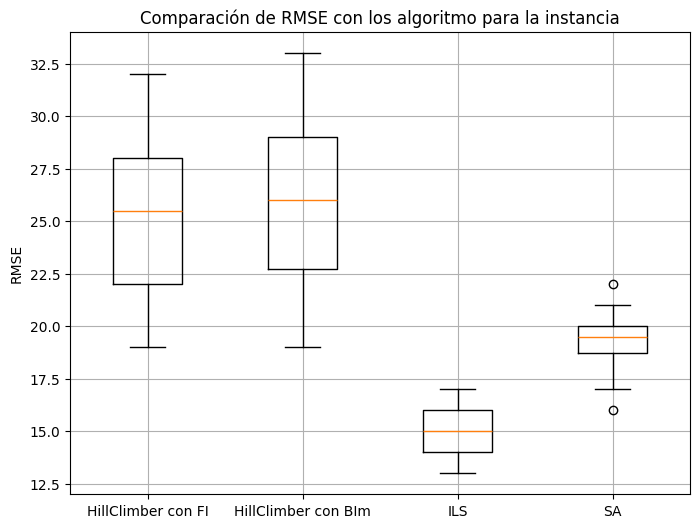

In [ ]:
#Los calculos de RMSE en de los archivos

instances = [prefix + "bcspwr02.txt"]
algorithms = ["HillClimber-FirstImprovement", "HillClimber-BestImprovement", "ILS", "SA"]

# Estructura para almacenar los RMSE individualmente
rmse_data = {instance: {algo_name: [] for algo_name in algorithms} for instance in instances}

for instance in instances:
    # Leer los objectivos de lo sarchivos
    _, target_value, _, _ = leer_grafo(instance)

    for algo_name in algorithms:
        # Leer los resultados desde el archivo correspondiente
        result_filename = f"{instance}_{algo_name}_results.txt"
        costs = read_val(result_filename)

        # Calcular RMSE individuales y almacenarlos
        rmse_values = calculate_rmse_individual(costs, target_value)
        rmse_data[instance][algo_name] = rmse_values

#Aqui se hacen los grafos
for instance in instances:
    # Preparar los datos para el gráfico
    data = []
    labels = []

    for algo_name in algorithms:
        # Obtener la lista de RMSE para cada algoritmo
        rmse_values = rmse_data[instance][algo_name]
        data.append(rmse_values)  # Matplotlib espera listas anidadas
        labels.append(algo_name)

    # Crear el boxplot para las comparaciones
    plt.figure(figsize=(8,6))
    plt.boxplot(data, labels=["HillClimber con FI", "HillClimber con BIm", "ILS", "SA"])  
    plt.title(f"Comparación de RMSE con los algoritmo para la instancia")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show()